# HiddenLayer Graph Demo - Keras

In [1]:
# Hide GPUs. Not needed for this demo.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Import Keras pre-trained models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
import tensorflow.keras.backend as K

import hiddenlayer as hl
import hiddenlayer.transforms as ht

## VGG 16

In [2]:
# Set the learning phase to inference
K.set_learning_phase(0)

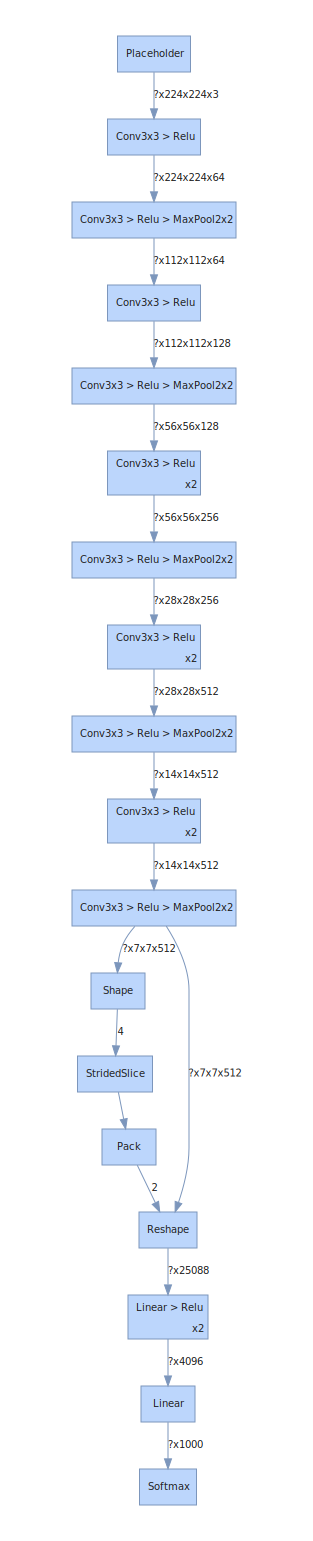

In [3]:
# Build the model
model = VGG16(input_shape=(224, 224, 3))

# Build model graph view
hl_graph = hl.build_graph(K.get_session().graph)

# Display graph view
hl_graph.theme = hl.graph.THEMES["blue"].copy()
hl_graph

## Transforms and Graph Expressions

A Graph Expression is like a Regular Expression for graphs. It simplifies searching for nodes that fit a particular pattern. For example, the graph expression `Conv > Relu` will find Conv layers that are followed by RELU layers. And the expressions `Conv | MaxPool` will match any Conv and MaxPool layers that are in parallel branches (i.e. have the same parent node). See examples of more complex graph expressions below.

Once the graph expression finds the nodes, we use Transforms to modify them. For example, if we want to delete all nodes of type `Const`, we'll use the transform `Prune("Const")`. The graph expression here is simple, `Const`, which matches any node with operation of type Const. And the Prune() transform deletes the node.

See more examples below. And, also, check `SIMPLICITY_TRANSFORMS` in `transforms.py`.

## VGG19

In [4]:
# Create a new graph and set the learning phase to inference
K.clear_session()
K.set_learning_phase(0)

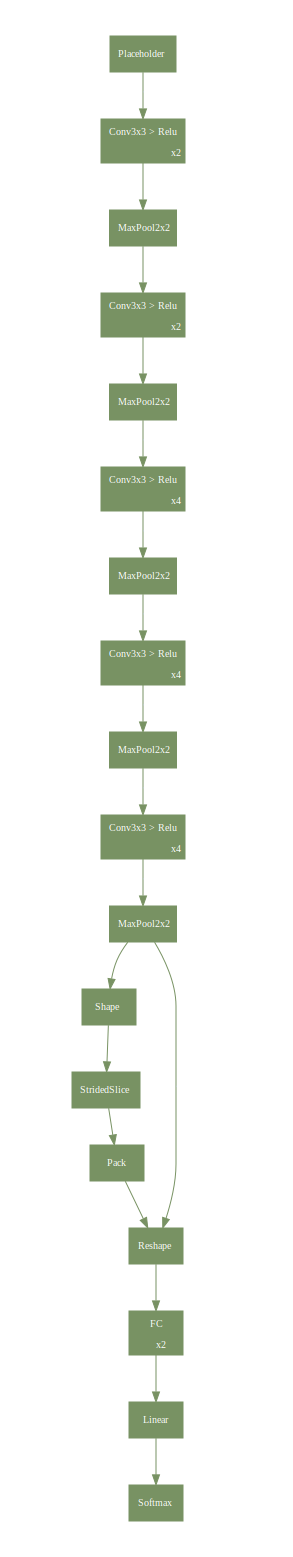

In [5]:
# Build the model
model = VGG19(input_shape=(224, 224, 3))

# Define custom transforms to group nodes differently
transforms = [
    # Build basic folds first
    ht.Fold("Conv > Relu", "ConvRelu"),
    # Display fully-connected layers differently
    ht.Fold("Linear > Relu", "FC", "FC"),
    # Fold repeated nodes
    ht.FoldDuplicates(),
]

# Build model graph view
hl_graph = hl.build_graph(K.get_session().graph, transforms=transforms)

# Customize the theme. The theme is a simple dict defined in graph.py
hl_graph.theme.update({
    "fill_color": "#789263",
    "outline_color": "#789263",
    "font_color": "#FFFFFF",
})

# Display graph view
hl_graph

## Xception with Xception module

In [6]:
# Create a new graph and set the learning phase to inference
K.clear_session()
K.set_learning_phase(0)

In [7]:
# Build the model
model = Xception(input_shape=(399, 399, 3))

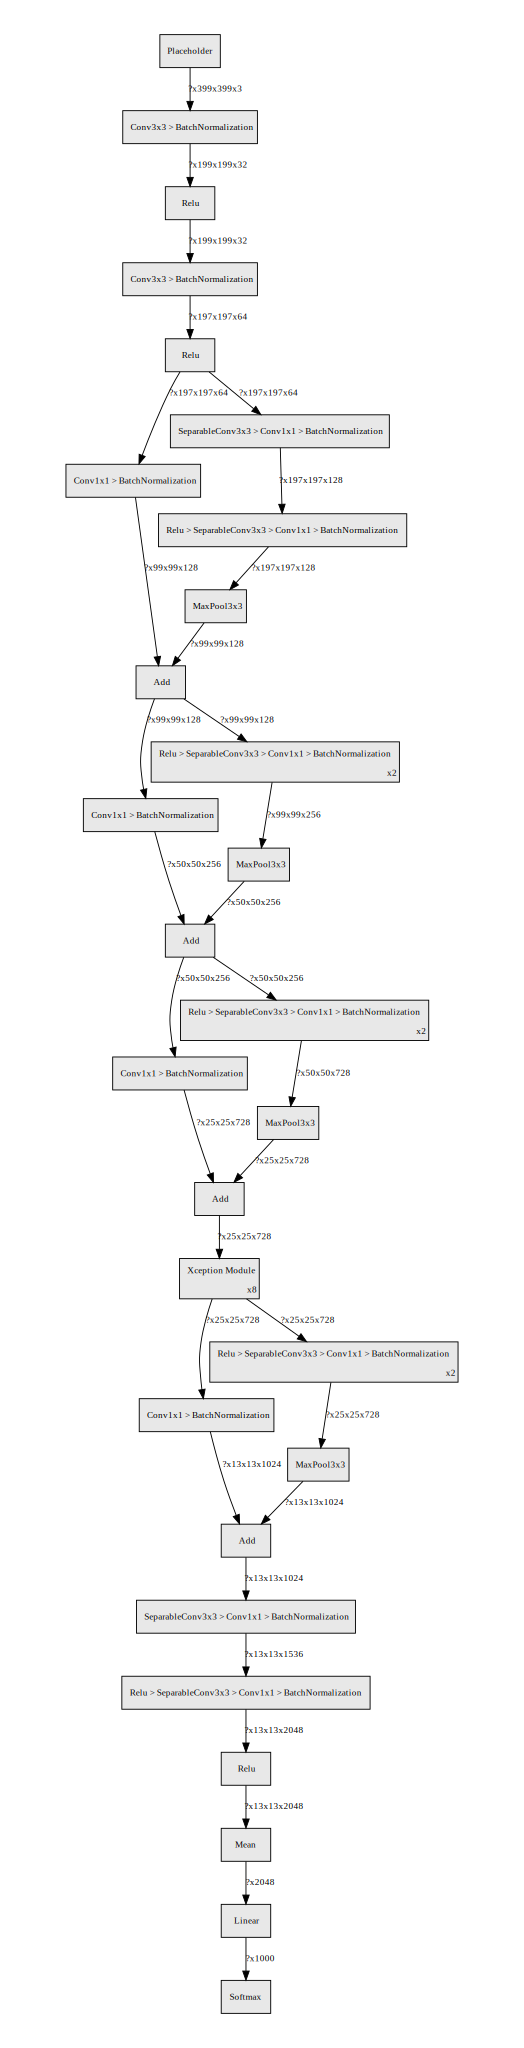

In [8]:
# Define custom transforms to group nodes of the Xception module
transforms = [
    # Build basic folds first
    ht.Fold("Conv > BatchNormalization", "ConvBn"),
    # ht.Fold("ConvBn > Relu", "ConvBnRelu"),
    # Next, build higher level folds that use basic folds
    ht.Fold("SeparableConv > ConvBn", "SepConvConvBn"),
    ht.Fold("Relu > SepConvConvBn", "ReluSepConvConvBn"),
    # Finally, build the Xception module
    ht.Fold("ReluSepConvConvBn > ReluSepConvConvBn > ReluSepConvConvBn > Add", "Xception", "Xception Module"),
    # Fold repeated nodes
    ht.FoldDuplicates(),
]

# Build model graph view
hl_graph = hl.build_graph(K.get_session().graph, transforms=transforms)

# Display graph view
hl_graph

## ResNet50 with Bottleneck and Residual blocks

In [9]:
# Create a new graph and set the learning phase to inference
K.clear_session()
K.set_learning_phase(0)

In [10]:
# Build the model
model = ResNet50(input_shape=(224, 224, 3))

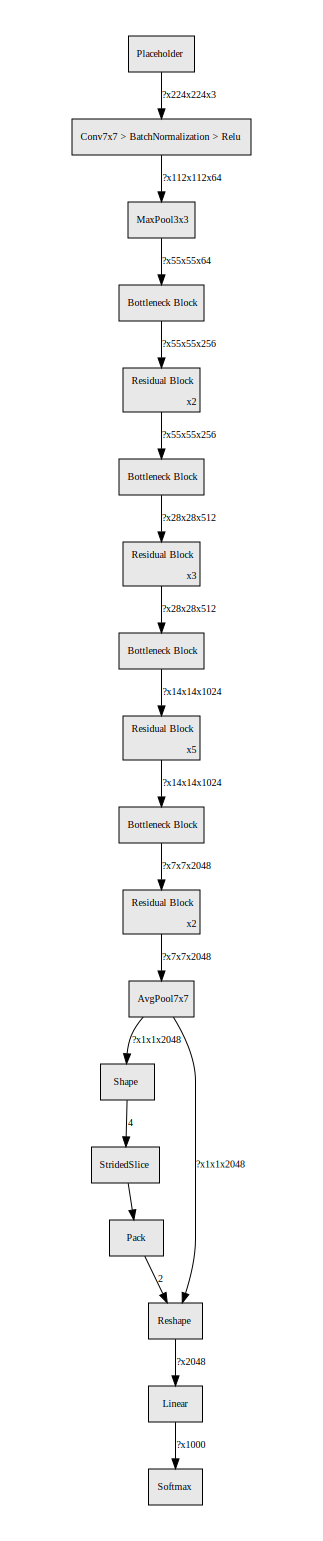

In [11]:
# Define custom transforms to group nodes of the bottleneck and residual blocks
transforms = [
    # Build basic folds first
    ht.Fold("Conv > BatchNormalization", "ConvBn"),
    ht.Fold("ConvBn > Relu", "ConvBnRelu"),
    # Fold bottleneck blocks
    ht.Fold("((ConvBnRelu > ConvBnRelu > ConvBn) | ConvBn) > Add > Relu", "BottleneckBlock", "Bottleneck Block"),
    # Fold residual blocks
    ht.Fold("ConvBnRelu > ConvBnRelu > ConvBn > Add > Relu", "ResBlock", "Residual Block"),
    ht.FoldDuplicates(),
]

# Build model graph view and display it
hl_graph = hl.build_graph(K.get_session().graph, transforms=transforms)
hl_graph

## InceptionV3 with 3 Types of Inception Modules

In [12]:
# Create a new graph and set the learning phase to inference
K.clear_session()
K.set_learning_phase(0)

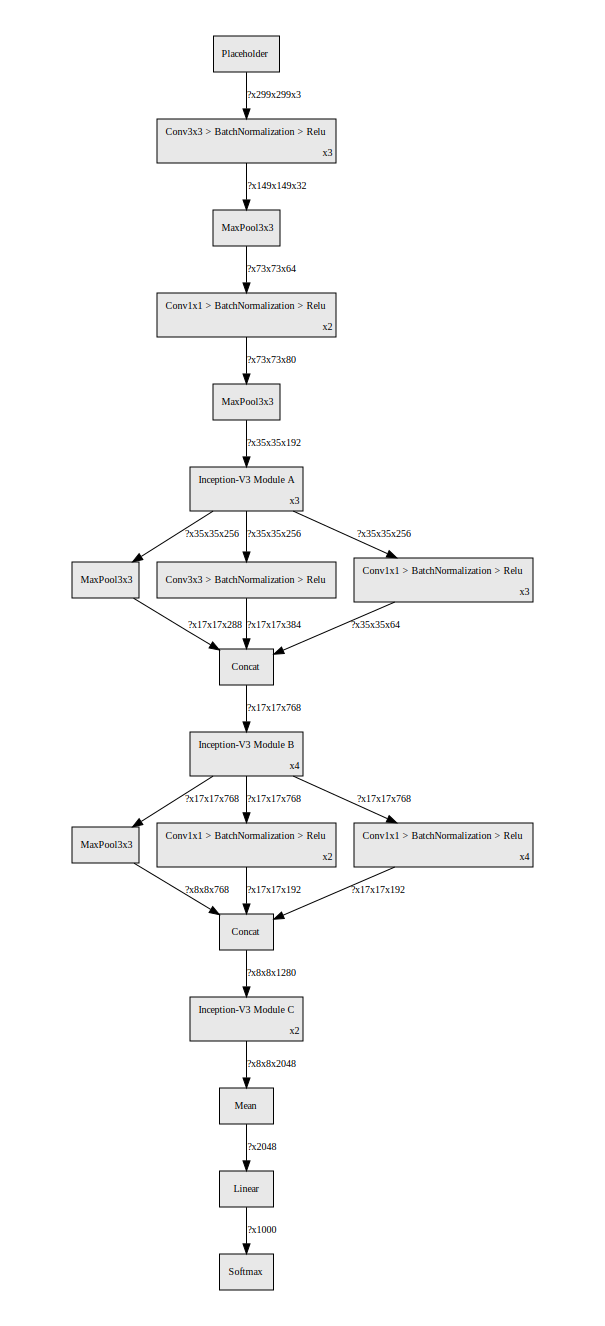

In [13]:
# Build the model
model = InceptionV3(input_shape=(299, 299, 3))

# Define custom transforms to group nodes into modules
transforms = [
    # Build basic folds first
    ht.Fold("Conv > BatchNormalization", "ConvBn"),
    ht.Fold("ConvBn > Relu", "ConvBnRelu"),
    # Fold nodes into inception modules
    ht.Fold("""
        ( (AvgPool > ConvBnRelu) |
          (ConvBnRelu) |
          (ConvBnRelu > ConvBnRelu) |
          (ConvBnRelu > ConvBnRelu > ConvBnRelu)
        ) > Concat
        """, "Inception-V3", "Inception-V3 Module A"),
    ht.Fold("""
        ( (AvgPool > ConvBnRelu) |
          (ConvBnRelu) |
          (ConvBnRelu > ConvBnRelu > ConvBnRelu) |
          (ConvBnRelu > ConvBnRelu > ConvBnRelu > ConvBnRelu > ConvBnRelu)
        ) > Concat
        """, "Inception-V3", "Inception-V3 Module B"),
    ht.Fold("""
        ( (AvgPool > ConvBnRelu) |
          (ConvBnRelu) |
          (ConvBnRelu > (ConvBnRelu | ConvBnRelu) > Concat) |
          (ConvBnRelu > ConvBnRelu > (ConvBnRelu | ConvBnRelu) > Concat)
        ) > Concat
        """, "Inception-V3", "Inception-V3 Module C"),
    ht.FoldDuplicates(),
]

# Build model graph view and display it
hl_graph = hl.build_graph(K.get_session().graph, transforms=transforms)
hl_graph

## MobileNet with ReLU6

In [14]:
# Create a new graph and set the learning phase to inference
K.clear_session()
K.set_learning_phase(0)

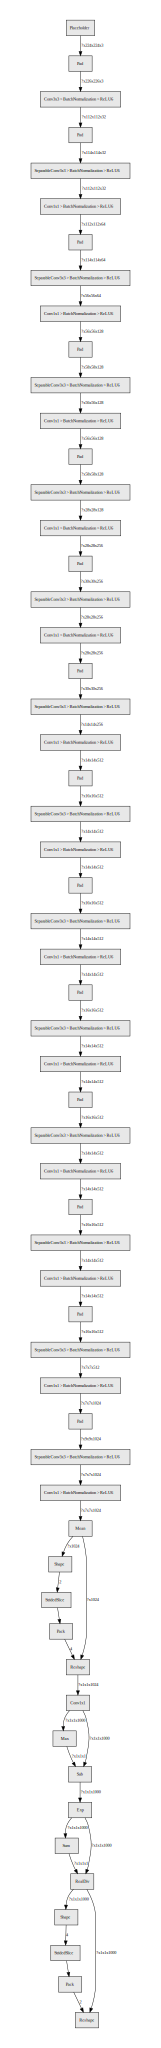

In [15]:
# Build the model
model = MobileNet(input_shape=(224, 224, 3))

# Define custom transforms to group nodes into modules
transforms = [
    # Build basic folds first
    # Note that the activation function used by MobileNet is ReLU6
    # The authors of the MobileNet paper found it more robust than regular ReLU in fixed-point inference
    ht.Fold("Relu > Minimum > Maximum", "Relu", "ReLU6"),
    ht.Fold("Conv > BatchNormalization", "ConvBn"),
    ht.Fold("ConvBn > Relu", "ConvBnRelu"),
    ht.Fold("SeparableConv > BatchNormalization", "SeparableConvBn"),
    ht.Fold("SeparableConvBn > Relu", "SeparableConvBnRelu"),
    # You could further simplify the graph by folding nodes into "depthwise separable” convolution blocks
    # To do so, simply uncomment the line below:
    # ht.Fold("SeparableConvBnRelu > ConvBnRelu > Pad", "Depthwise Separable Conv Block", "Depthwise Separable Conv Block"),
    ht.FoldDuplicates(),
]

# Build model graph view and display it
hl_graph = hl.build_graph(K.get_session().graph, transforms=transforms)
hl_graph

## DenseNet121 with 4 DenseNet-B Blocks (x6, x12, x24, x16)

In [16]:
# Create a new graph and set the learning phase to inference
K.clear_session()
K.set_learning_phase(0)

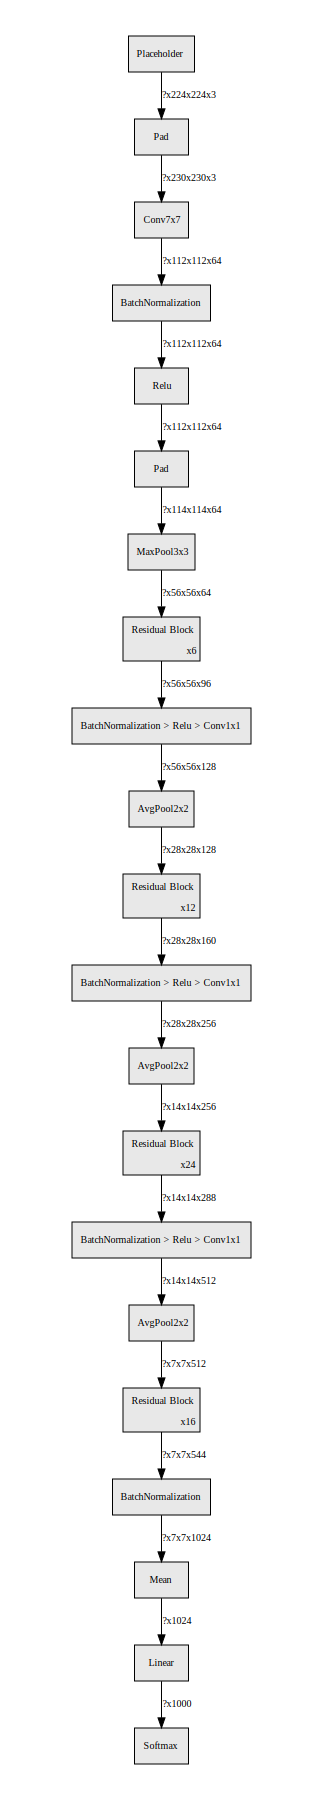

In [17]:
# Build the model
model = DenseNet121(input_shape=(224, 224, 3))

# Define custom transforms to group nodes into modules
transforms = [
    # Build basic folds first
    ht.Fold("BatchNormalization > Relu > Conv", "BnReluConv"),
    ht.Fold("BnReluConv > BnReluConv> Concat", "ResBlock", "Residual Block"),
    ht.FoldDuplicates(),
]

# Build model graph view and display it
hl_graph = hl.build_graph(K.get_session().graph, transforms=transforms)
hl_graph